In [ ]:
import torch
import random
from torch.utils.data import DataLoader, Dataset
import skimage.transform as skt
from torchvision.utils import make_grid, save_image
from torch.optim import Adam
import torch.nn as nn

In [4]:
class ImagePairDataset(Dataset): 
    def __init__(self, img_fnames, **transform_args): 
        self.img_fnames = img_fnames 
        self.transform_args = transform_args 
    
    def __len__(self): return len(self.img_fnames) 
    
    def __getitem__(self, idx): 
        img1 = skio.imread(self.img_fnames[idx][0])
        img2 = skio.imread(self.img_fnames[idx][1]) 
        img1 = skt.resize(img1, (self.transform_args['img_size'], self.transform_args['img_size']), order=0) 
        img1 = img_as_float(img1) 
        img1 = torch.from_numpy(img1).float()[None, :] 
        img2 = skt.resize(img2, (self.transform_args['img_size'], self.transform_args['img_size']), order=0) 
        img2 = img_as_float(img2) 
        img2 = torch.from_numpy(img2).float()[None, :]
        return img1, img2 
        
def prepare_train_valid_loader(file_dirs, split=0.2, bs=64, nw=0, **transform_args): 
    random.shuffle(file_dirs) 
    split_idx = int(np.floor(len(file_dirs)*split)) 
    train_dataset = ImagePairDataset(file_dirs[split_idx:], **transform_args) 
    train_loader = DataLoader(train_dataset, batch_size=bs, num_workers=nw) 
    if split>0: 
        valid_dataset = ImagePairDataset(file_dirs[:split_idx], **transform_args) 
        valid_loader = DataLoader(valid_dataset, batch_size=bs, num_workers=nw) 
        return train_loader, valid_loader 
    else: valid_loader=None 
    return train_loader, valid_loader

In [5]:
unet = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=1, out_channels=1, init_features=8, pretrained=False)

Using cache found in C:\Users\lociuser/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master


In [8]:
in_fnames = glob(path.join(data_folder, 'training', 'noisy', '*.tif'))
out_fnames = glob(path.join(data_folder, 'training', 'clean', '*.tif'))
pair_fnams = list(zip(in_fnames, out_fnames))
train_loader, valid_loader = prepare_train_valid_loader(pair_fnams, split=0.2, bs=8, nw=0, img_size=512)

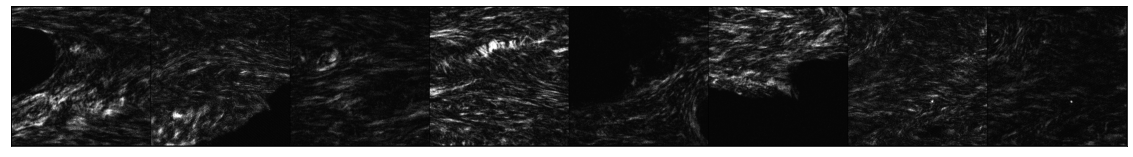

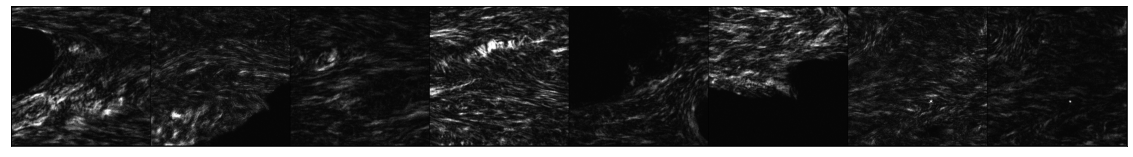

In [9]:
import matplotlib.pyplot as plt 
import torchvision.transforms.functional as F
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(20, 20))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
for in_img, out_img in train_loader:      
    in_grid = make_grid(in_img)
    out_grid = make_grid(out_img)
    show(in_grid)
    show(out_grid)
    break

In [10]:
class Denoiser:
    def __init__(self, working_dir, backbone, loss_fn, lr, train_loader, valid_loader=None, cuda=True):
        self.backbone = backbone
        self.loss_fn = loss_fn
        self.optimizer = Adam(self.backbone.parameters(), lr=lr)
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.train_loss_log = []
        self.valid_loss_log = []
        self.working_dir = working_dir
        os.makedirs(path.join(self.working_dir, 'output'), exist_ok=True)
        self.cuda = cuda
        if self.cuda:
            self.loss_fn.cuda()
            self.backbone.cuda()

    def train(self, num_epoch):
        self.backbone.train()
        for e in range(num_epoch):
            for i, batch in enumerate(self.train_loader):
                self.optimizer.zero_grad()
                if self.cuda():
                    in_img = batch[0].cuda()
                    target_img = batch[1].cuda()
                else:
                    in_img = batch[0]
                    target_img = batch[1]
                out_img = self.backbone[in_img]
                loss = self.loss_fn(out_img, target_img)
                loss.backward()
                self.optimizer.step()
                log = f'[train] epoch {e}/{num_epoch} iter {i}/{len(self.train_loader)} loss: {loss.item()}'
                self.train_loss_log.append(log)
                print(log)
            if e % 5 == 0:
                self.test(e, num_epoch)

    def test(self, e, num_epoch, print=True):
        with torch.no_grad():
            self.backbone.eval()
            for i, batch in enumerate(self.valid_loader):
                if self.cuda():
                    in_img = batch[0].cuda()
                    target_img = batch[1].cuda()
                else:
                    in_img = batch[0]
                    target_img = batch[1]
                out_img = self.backbone[in_img]
                loss = self.loss_fn(out_img, target_img)
                log = f'[test] epoch {e}/{num_epoch} iter {i}/{len(self.test_loader)} loss: {loss.item()}'
                self.valid_loss_log.append(log)
                print(log)
            if print:
                out_dir = path.join(self.working_dir, 'output')
                in_fname = path.join(out_dir, f'input_epoch_{e}/{num_epoch}.tif')
                out_fname = path.join(out_dir, f'output_epoch_{e}/{num_epoch}.tif')
                target_fname = path.join(out_dir, f'target_epoch_{e}/{num_epoch}.tif')
                save_image(in_img, in_fname)
                save_image(out_img, out_fname)
                save_image(target_img, target_fname)

In [11]:
criterion = nn.MSELoss()
lr = 0.0001

In [12]:
denoiser = Denoiser('denoiser', unet, criterion, lr, train_loader, valid_loader , cuda=True)

AssertionError: Torch not compiled with CUDA enabled

In [8]:
from skimage import img_as_float, img_as_uint
from skimage import io 
from glob import glob
from skimage import transform, filters
import os

In [10]:
inputs = glob('datasets/lsm-pair/target/*.tif')
output_dir = 'datasets/lsm-pair/input'
for fname in inputs:
    img = io.imread(fname)
    img = img_as_float(img)
    img = transform.rescale(img, 0.25, order=0)
    # img = filters.median(img)
    io.imsave(os.path.join(output_dir, os.path.basename(fname)), img_as_uint(img))

C:\Users\bli346\AppData\Local\Temp\ipykernel_10372\2941263670.py:8: UserWarning: datasets/lsm-pair/input\PCCP___PDAC_MetroHealth_003_a-lsm--12157_10338.ome___2_3.tif is a low contrast image
  io.imsave(os.path.join(output_dir, os.path.basename(fname)), img_as_uint(img))
C:\Users\bli346\AppData\Local\Temp\ipykernel_10372\2941263670.py:8: UserWarning: datasets/lsm-pair/input\PCCP___PDAC_MetroHealth_003_a-lsm--12157_10338.ome___3_1.tif is a low contrast image
  io.imsave(os.path.join(output_dir, os.path.basename(fname)), img_as_uint(img))
C:\Users\bli346\AppData\Local\Temp\ipykernel_10372\2941263670.py:8: UserWarning: datasets/lsm-pair/input\PCCP___PDAC_MetroHealth_003_a-lsm--12157_10338.ome___3_2.tif is a low contrast image
  io.imsave(os.path.join(output_dir, os.path.basename(fname)), img_as_uint(img))
C:\Users\bli346\AppData\Local\Temp\ipykernel_10372\2941263670.py:8: UserWarning: datasets/lsm-pair/input\PCCP___PDAC_MetroHealth_003_a-lsm--12157_10338.ome___3_3.tif is a low contrast ima

In [1]:
from lsm_utils import process_pmm_datasets
from glob import glob
from pycromanager import Dataset as PDataset
from os import path

In [2]:
process_pmm_datasets('pmm_datasets/PA2081b_clean', 'datasets/PA_2081b/clean')

  0%|          | 0/90 [00:00<?, ?it/s]

Dataset opened                 


  1%|          | 1/90 [00:46<1:08:19, 46.06s/it]

Dataset opened                 


  2%|▏         | 2/90 [01:29<1:05:05, 44.38s/it]

Dataset opened                 


  3%|▎         | 3/90 [02:30<1:15:20, 51.96s/it]

Dataset opened                 


  4%|▍         | 4/90 [02:42<52:14, 36.45s/it]  

Dataset opened                 


  6%|▌         | 5/90 [02:55<39:34, 27.93s/it]

Dataset opened                 


  7%|▋         | 6/90 [03:38<46:14, 33.03s/it]

Dataset opened                 


  8%|▊         | 7/90 [03:54<38:05, 27.54s/it]

Dataset opened                 


  9%|▉         | 8/90 [04:08<31:43, 23.22s/it]

Dataset opened                 


 10%|█         | 9/90 [04:27<29:26, 21.81s/it]

Dataset opened                 


 11%|█         | 10/90 [04:45<27:28, 20.61s/it]

Dataset opened                 


 12%|█▏        | 11/90 [04:57<23:42, 18.01s/it]

Dataset opened                 


 13%|█▎        | 12/90 [05:15<23:26, 18.03s/it]

Dataset opened                 


 14%|█▍        | 13/90 [05:29<21:21, 16.64s/it]

Dataset opened                 


 16%|█▌        | 14/90 [05:44<20:35, 16.25s/it]

Dataset opened                 


 17%|█▋        | 15/90 [06:12<24:55, 19.94s/it]

Dataset opened                 


 18%|█▊        | 16/90 [07:01<35:12, 28.54s/it]

Dataset opened                 


 19%|█▉        | 17/90 [07:52<43:06, 35.43s/it]

Dataset opened                 


 20%|██        | 18/90 [08:52<51:11, 42.66s/it]

Dataset opened                 


 21%|██        | 19/90 [12:25<1:51:03, 93.85s/it]

Dataset opened                 


 22%|██▏       | 20/90 [12:49<1:25:01, 72.88s/it]

Dataset opened                 


 23%|██▎       | 21/90 [13:03<1:03:18, 55.06s/it]

Dataset opened                 


 24%|██▍       | 22/90 [13:20<49:26, 43.62s/it]  

Dataset opened                 


 26%|██▌       | 23/90 [13:55<45:59, 41.18s/it]

Dataset opened                 


 27%|██▋       | 24/90 [14:17<39:04, 35.52s/it]

Dataset opened                 


 28%|██▊       | 25/90 [14:33<31:52, 29.42s/it]

Dataset opened                 


 29%|██▉       | 26/90 [14:55<29:09, 27.34s/it]

Dataset opened                 


 30%|███       | 27/90 [15:12<25:34, 24.35s/it]

Dataset opened                 


 31%|███       | 28/90 [15:26<21:45, 21.05s/it]

Dataset opened                 


 32%|███▏      | 29/90 [15:46<21:01, 20.68s/it]

Dataset opened                 


 33%|███▎      | 30/90 [16:02<19:16, 19.28s/it]

Dataset opened                 


 34%|███▍      | 31/90 [16:29<21:25, 21.79s/it]

Dataset opened                 


 36%|███▌      | 32/90 [17:15<28:08, 29.12s/it]

Dataset opened                 


 37%|███▋      | 33/90 [18:07<34:10, 35.97s/it]

Dataset opened                 


 38%|███▊      | 34/90 [19:00<38:20, 41.08s/it]

Dataset opened                 


 39%|███▉      | 35/90 [21:28<1:06:53, 72.98s/it]

Dataset opened                 


 40%|████      | 36/90 [23:03<1:11:42, 79.67s/it]

Dataset opened                 


 41%|████      | 37/90 [23:17<53:01, 60.02s/it]  

Reading index...          

c:\Users\bli346\Anaconda3\envs\pt\lib\site-packages\pycromanager\data.py:180: UserWarning: Index appears to not have been properly terminated (the dataset may still work)
  warnings.warn(
 42%|████▏     | 38/90 [23:18<36:32, 42.17s/it]

Dataset opened                 
Dataset opened                 


 43%|████▎     | 39/90 [23:31<28:31, 33.56s/it]

Dataset opened                 


 44%|████▍     | 40/90 [24:03<27:30, 33.02s/it]

Dataset opened                 


 46%|████▌     | 41/90 [24:30<25:36, 31.36s/it]

Dataset opened                 


 47%|████▋     | 42/90 [24:49<21:55, 27.41s/it]

Dataset opened                 


 48%|████▊     | 43/90 [25:05<18:56, 24.18s/it]

Dataset opened                 


 49%|████▉     | 44/90 [25:19<16:13, 21.16s/it]

Dataset opened                 


 50%|█████     | 45/90 [25:36<14:47, 19.73s/it]

Dataset opened                 


 51%|█████     | 46/90 [25:52<13:38, 18.61s/it]

Dataset opened                 


 52%|█████▏    | 47/90 [26:07<12:32, 17.51s/it]

Dataset opened                 


 53%|█████▎    | 48/90 [26:29<13:20, 19.06s/it]

Dataset opened                 


 54%|█████▍    | 49/90 [26:51<13:35, 19.89s/it]

Dataset opened                 


 56%|█████▌    | 50/90 [27:08<12:36, 18.92s/it]

Dataset opened                 


 57%|█████▋    | 51/90 [27:28<12:33, 19.32s/it]

Dataset opened                 


 58%|█████▊    | 52/90 [27:55<13:42, 21.65s/it]

Dataset opened                 


 59%|█████▉    | 53/90 [28:08<11:37, 18.85s/it]

Dataset opened                 


 60%|██████    | 54/90 [28:22<10:27, 17.43s/it]

Dataset opened                 


 61%|██████    | 55/90 [28:36<09:40, 16.58s/it]

Dataset opened                 


 62%|██████▏   | 56/90 [28:48<08:37, 15.22s/it]

Dataset opened                 


 63%|██████▎   | 57/90 [29:05<08:34, 15.59s/it]

Dataset opened                 


 64%|██████▍   | 58/90 [29:20<08:13, 15.43s/it]

Dataset opened                 


 66%|██████▌   | 59/90 [29:33<07:37, 14.75s/it]

Dataset opened                 


 67%|██████▋   | 60/90 [29:45<06:54, 13.80s/it]

Dataset opened                 


 68%|██████▊   | 61/90 [29:56<06:22, 13.17s/it]

Dataset opened                 


 69%|██████▉   | 62/90 [30:10<06:12, 13.32s/it]

Dataset opened                 


 70%|███████   | 63/90 [30:23<05:56, 13.20s/it]

Dataset opened                 


 71%|███████   | 64/90 [30:41<06:23, 14.74s/it]

Dataset opened                 


 72%|███████▏  | 65/90 [30:56<06:05, 14.64s/it]

Dataset opened                 


 73%|███████▎  | 66/90 [31:10<05:47, 14.49s/it]

Dataset opened                 


 74%|███████▍  | 67/90 [31:23<05:27, 14.24s/it]

Dataset opened                 


 76%|███████▌  | 68/90 [31:39<05:21, 14.63s/it]

Dataset opened                 


 77%|███████▋  | 69/90 [31:54<05:07, 14.63s/it]

Dataset opened                 


 78%|███████▊  | 70/90 [32:07<04:42, 14.13s/it]

Dataset opened                 


 79%|███████▉  | 71/90 [32:24<04:49, 15.22s/it]

Dataset opened                 


 80%|████████  | 72/90 [32:36<04:16, 14.23s/it]

Dataset opened                 


 81%|████████  | 73/90 [32:51<04:05, 14.44s/it]

Dataset opened                 


 82%|████████▏ | 74/90 [33:07<03:57, 14.86s/it]

Dataset opened                 


 83%|████████▎ | 75/90 [33:22<03:45, 15.03s/it]

Dataset opened                 


 84%|████████▍ | 76/90 [33:36<03:24, 14.61s/it]

Dataset opened                 


 86%|████████▌ | 77/90 [33:49<03:04, 14.21s/it]

Dataset opened                 


 87%|████████▋ | 78/90 [34:05<02:54, 14.54s/it]

Dataset opened                 


 88%|████████▊ | 79/90 [34:18<02:37, 14.31s/it]

Dataset opened                 


 89%|████████▉ | 80/90 [34:36<02:32, 15.27s/it]

Dataset opened                 


 90%|█████████ | 81/90 [34:49<02:12, 14.74s/it]

Dataset opened                 


 91%|█████████ | 82/90 [35:02<01:53, 14.15s/it]

Dataset opened                 


 92%|█████████▏| 83/90 [35:16<01:37, 13.96s/it]

Dataset opened                 


 93%|█████████▎| 84/90 [35:29<01:22, 13.75s/it]

Dataset opened                 


 94%|█████████▍| 85/90 [35:43<01:08, 13.71s/it]

Dataset opened                 


 96%|█████████▌| 86/90 [35:55<00:53, 13.47s/it]

Dataset opened                 


 97%|█████████▋| 87/90 [36:08<00:39, 13.33s/it]

Dataset opened                 


 98%|█████████▊| 88/90 [36:21<00:26, 13.03s/it]

Dataset opened                 


 99%|█████████▉| 89/90 [36:35<00:13, 13.50s/it]

Dataset opened                 


100%|██████████| 90/90 [36:49<00:00, 24.55s/it]


In [13]:
training_data = glob(path.join('pmm_datasets/PA2081b_noisy', '*/'))
dataset = PDataset(training_data[-1])

Dataset opened                 


In [18]:
dataset.as_array()

,Array,Chunk
Bytes,60.00 MiB,128.00 kiB
Shape,"(4, 1, 120, 256, 256)","(1, 1, 1, 256, 256)"
Count,960 Tasks,480 Chunks
Type,uint16,numpy.ndarray


In [43]:
from glob import glob
from os import path 
clean_data = [path.basename(i)[:33]+path.basename(i)[34:] for i in glob(path.join('datasets/PA_2081b/clean', '*'))]
noisy_data = [path.basename(i)[:33]+path.basename(i)[34:] for i in glob(path.join('datasets/PA_2081b/noisy', '*'))]

In [49]:
clean_data[-1]

'PA2081b_0709_train-lsm-slow--M-7_---99---3.tif'

In [50]:
noisy_data[-1]

'PA2081b_0709_train-lsm-slow--M-7_---3---99.tif'

In [44]:
diff_files = list(set(clean_data)-set(noisy_data))
len(diff_files)

41312

In [42]:
fname[:33]+fname[34:]

'PA2081b_0709_train-lsm-slow--A-1_---0---0.tif'

In [39]:
c = 0
for i in glob(path.join('datasets/PA_2081b/noisy', '*')):
    fname = path.basename(i)
    striped_name = fname[:30]+fname[34:]
    if striped_name in diff_files:
        c += 1
    break

In [40]:
fname

'PA2081b_0709_train-lsm-slow--A-1_3---0---0.tif'

In [41]:
striped_name

'PA2081b_0709_train-lsm-slow--A---0---0.tif'

In [35]:
fname

'PA2081b_0709_train-lsm-slow--M-7_1---3---99.tif'

In [8]:
import torch.nn as nn 
import torch 
loss = nn.MSELoss(reduction='none')
input = torch.randn((4, 1, 64, 64), requires_grad=False)
output = torch.randn((4, 1, 64, 64), requires_grad=False)

In [11]:
ms = torch.mean(loss(input, output), (1, 2, 3))

In [12]:
ms.shape

torch.Size([4])